In [2]:
from mne.minimum_norm import apply_inverse, make_inverse_operator
import mne

# Source Localization - Production and Comprehension Priming Study
Everything in this notebook is automatic except for the **covariance rank**. The MNE function to automatically calculate the rank does not work well. Instead of using that, it is necessary to manually set the rank for each subject/task. Test values until you find one that creates a vertical line right before the noise drops off dramatically. You should see a small slope directly to the left of the rank line. If you do not manually set the rank, your inverse operator will only explain a very small percent of the variance in the original data.

In [ ]:
sub = 'R3290' #Only variable you need to change other than rank

In [3]:
# Setting parameters to be used by both production and comprehension
subjects_dir = '/Applications/freesurfer/8.0.0/subjects' # freesurfer MRI directory
directory = '/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/' + sub + '/'

conductivity = (0.3,) # single layer conductivity
baseline_start = -300 #in milliseconds
baseline_end = 0
baseline = (None,0)
snr = 3.0
method = "dSPM"

# LOAD COMPREHENSION AND PRODUCTION DATA
# load epochs
epoch_fname_comp = directory + sub + '_comp-epo.fif'
epochs_comp = mne.read_epochs(epoch_fname_comp, proj=False)
epoch_fname_prod = directory + sub + '_prod-epo.fif'
epochs_prod = mne.read_epochs(epoch_fname_prod, proj=False)


# Reject bad epochs that have a max peak to peak signal amplitude that exceeds 3 picoteslas
reject_criteria = dict(mag=3000e-15)
epochs_prod.drop_bad(reject=reject_criteria)
epochs_comp.drop_bad(reject=reject_criteria)


# Equalize epoch counts for each condition
ident_prod = epochs_prod['production identical'].pick('mag')
unrel_prod = epochs_prod['production unrelated'].pick('mag')
ident_comp = epochs_comp['comprehension identical'].pick('mag')
unrel_comp = epochs_comp['comprehension unrelated'].pick('mag')
mne.epochs.equalize_epoch_counts([ident_prod, ident_comp, unrel_prod, unrel_comp], method="random")

# Create evoked objects low pass filtered at 40 Hz
ident_prod = ident_prod.average().filter(l_freq=None, h_freq=40)
unrel_prod = unrel_prod.average().filter(l_freq=None, h_freq=40)
ident_comp = ident_comp.average().filter(l_freq=None, h_freq=40)
unrel_comp = unrel_comp.average().filter(l_freq=None, h_freq=40)

# Make anatomical model -- does not use head position information
subject = sub
model = mne.make_bem_model(subject=subject, ico=4, conductivity=conductivity, subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)
src = mne.setup_source_space(subject, spacing="oct6", add_dist="patch", subjects_dir=subjects_dir)

Reading /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3290/R3290_comp_TEST-epo.fif ...
    Read a total of 2 projection items:
        axial-Raw-0.000-120.000-PCA-01 (1 x 155) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 155) active
    Found the data of interest:
        t =    -300.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
150 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
Reading /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3290/R3290_prod_TEST-epo.fif ...
    Read a total of 2 projection items:
        axial-Raw-0.000-120.000-PCA-01 (1 x 155) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 155) active
    Found the data of interest:
        t =    -300.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
113 matching events found
No baseline correction applied
Created an SSP 

## Comprehension

    Created an SSP operator (subspace dimension = 2)
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 157 -> 147
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 42742
log-likelihood on unseen data (descending order):
   shrunk: -825.931
   empirical: -825.932
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.4e-14 (2.2e-16 eps * 157 dim * 0.41  max singular value)
    Estimated rank (mag): 147
    MAG: rank 147 computed from 157 data channels with 0 projectors


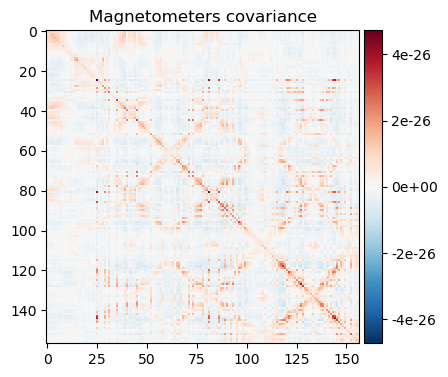

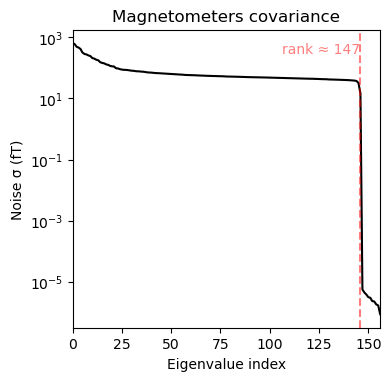

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [6]:
# Compute the noise covariance using the baseline interval
# rank = None
rank = {'mag': 147}
noise_cov_comp = mne.compute_covariance(epochs_comp, tmin=baseline_start, tmax=baseline_end,
                                        method=["shrunk", "empirical"], rank=rank, verbose=True)
mne.viz.plot_cov(noise_cov_comp, epochs_comp.info)

In [7]:
raw_fname_comp = directory + sub + '_comp_preproc-raw.fif'
trans = directory + sub + '-trans.fif'

# Compute forward solution
fwd_comp = mne.make_forward_solution(
    raw_fname_comp,
    trans=trans,
    src=src,
    bem=bem,
    meg=True,
    eeg=False,
    mindist=5.0,
    ignore_ref=True
)
lambda2 = 1.0 / snr ** 2

# Calculate inverse operators
inverse_ident_comp = make_inverse_operator(ident_comp.info, fwd_comp, noise_cov_comp, loose=0.2, depth=0.8)
inverse_unrel_comp = make_inverse_operator(unrel_comp.info, fwd_comp, noise_cov_comp, loose=0.2, depth=0.8)

# Calculate STCs using evoked data, inverse operators from above
stc_ident_comp = apply_inverse(ident_comp, inverse_ident_comp, lambda2, method=method, pick_ori="normal")
stc_unrel_comp = apply_inverse(unrel_comp, inverse_unrel_comp, lambda2, method=method, pick_ori="normal")

fname_ident_comp = directory + sub + '_ident_comp'
stc_ident_comp.save(fname_ident_comp, ftype='stc', overwrite=True)
fname_unrel_comp = directory + sub + '_unrel_comp'
stc_unrel_comp.save(fname_unrel_comp, ftype='stc', overwrite=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'R3290', ~31.3 MiB>
MRI -> head transform : /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3290/R3290-trans.fif
Measurement data      : R3290_comp_preproc.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999925 0.000256 -0.012222      -1.74 mm
    0.000441 0.998375 0.056985      32.31 mm
    0.012216 -0.056986 0.998300      37.93 mm
    0.000000 0.000000 0.000000       1.00

Read 157 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.991015 0.096724 -0.092382      -5.18 mm
    -0.085550 0.989312 0.118077      14.52 mm
    0.102816

## Production

    Created an SSP operator (subspace dimension = 2)
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 157 -> 148
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 33110
log-likelihood on unseen data (descending order):
   shrunk: -833.031
   empirical: -833.033
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.3e-14 (2.2e-16 eps * 157 dim * 0.36  max singular value)
    Estimated rank (mag): 148
    MAG: rank 148 computed from 157 data channels with 0 projectors


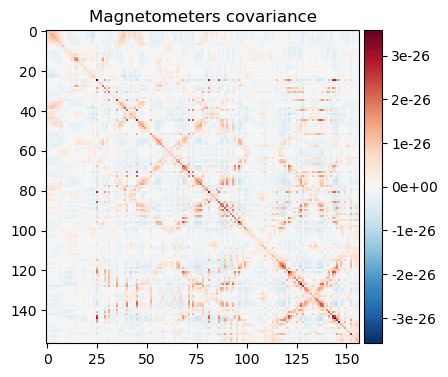

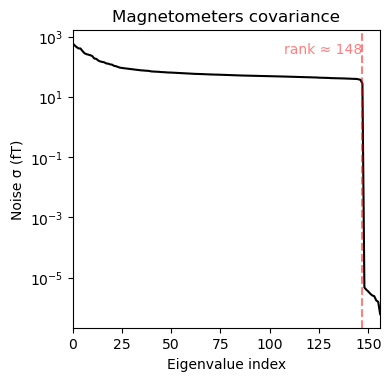

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [9]:
# Compute the noise covariance using the baseline interval
# rank = None
rank = {'mag': 148}
noise_cov_prod = mne.compute_covariance(epochs_prod, tmin=baseline_start, tmax=baseline_end, method=["shrunk", "empirical"], rank=rank, verbose=True)
mne.viz.plot_cov(noise_cov_prod, epochs_prod.info)

In [10]:
raw_fname_prod = directory + sub + '_prod_preproc-raw.fif'
trans = directory + sub + '-trans.fif'

# Compute forward solution
fwd_prod = mne.make_forward_solution(
    raw_fname_prod,
    trans=trans,
    src=src,
    bem=bem,
    meg=True,
    eeg=False,
    mindist=5.0,
    ignore_ref=True
)
lambda2 = 1.0 / snr ** 2

# Calculate inverse operators
inverse_ident_prod = make_inverse_operator(ident_prod.info, fwd_prod, noise_cov_prod, loose=0.2, depth=0.8)
inverse_unrel_prod = make_inverse_operator(unrel_prod.info, fwd_prod, noise_cov_prod, loose=0.2, depth=0.8)

# Calculate STCs using evoked data, inverse operators from above
stc_ident_prod = apply_inverse(ident_prod, inverse_ident_prod, lambda2, method=method, pick_ori="normal")
stc_unrel_prod = apply_inverse(unrel_prod, inverse_unrel_prod, lambda2, method=method, pick_ori="normal")

fname_ident_comp = directory + sub + '_ident_prod'
stc_ident_prod.save(fname_ident_comp, ftype='stc', overwrite=True)
fname_unrel_comp = directory + sub + '_unrel_prod'
stc_unrel_prod.save(fname_unrel_comp, ftype='stc', overwrite=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'R3290', ~31.3 MiB>
MRI -> head transform : /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3290/R3290-trans.fif
Measurement data      : R3290_prod_preproc.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999925 0.000256 -0.012222      -1.74 mm
    0.000441 0.998375 0.056985      32.31 mm
    0.012216 -0.056986 0.998300      37.93 mm
    0.000000 0.000000 0.000000       1.00

Read 157 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.991413 0.097555 -0.087079      -5.53 mm
    -0.085504 0.987452 0.132766      13.75 mm
    0.098938

## Plot generated STCs

In [14]:
stcs = {
        'Comprehension identical':stc_ident_comp,
        'Comprehension unrelated': stc_unrel_comp,
        'Production identical': stc_ident_prod,
        'Production unrelated':stc_unrel_prod,
}

brains = []

cmaps = ['hot', 'cool', 'spring', 'winter']
for (title, stc), cmap in zip(stcs.items(), cmaps):
    brain = stc.plot(
        subjects_dir=subjects_dir,
        hemi='lh',
        colormap=cmap,
        clim=dict(kind="value", lims=[3, 6, 9]),
        smoothing_steps=7,
        title=title
    )
    brain.add_text(0.1, 0.9, title, "title", font_size=14)
    brains.append(brain)  # Save each brain object


Using pyvistaqt 3d backend.


2025-08-25 15:02:51.355 python[81394:5612967] +[IMKClient subclass]: chose IMKClient_Modern
2025-08-25 15:02:51.355 python[81394:5612967] +[IMKInputSession subclass]: chose IMKInputSession_Modern


# Source Localization -- Auditory

In [51]:
sub = 'R3271'

In [52]:
# Setting parameters to be used by both production and comprehension
subjects_dir = '/Applications/freesurfer/8.0.0/subjects' # freesurfer MRI directory
directory = '/Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/' + sub + '/'

conductivity = (0.3,) # single layer conductivity
baseline_start = -300 #in milliseconds
baseline_end = 0
baseline = (None,0)
snr = 3.0
method = "dSPM"

# LOAD COMPREHENSION AND PRODUCTION DATA
# load epochs
epoch_fname_comp = directory + sub + '_comp_aud-epo.fif'
epochs_aud_comp = mne.read_epochs(epoch_fname_comp, proj=False)
epoch_fname_prod = directory + sub + '_prod_aud-epo.fif'
epochs_aud_prod = mne.read_epochs(epoch_fname_prod, proj=False)


# Reject bad epochs that have a max peak to peak signal amplitude that exceeds 3 picoteslas
reject_criteria = dict(mag=3000e-15)
epochs_aud_prod.drop_bad(reject=reject_criteria)
epochs_aud_comp.drop_bad(reject=reject_criteria)


# Equalize epoch counts for each condition
aud_prod = epochs_aud_prod['audio onset'].pick('mag')
aud_comp = epochs_aud_comp['audio onset'].pick('mag')
mne.epochs.equalize_epoch_counts([aud_prod, aud_comp], method="random")

# Create evoked objects low pass filtered at 40 Hz
aud_prod = aud_prod.average().filter(l_freq=None, h_freq=40)
aud_comp = aud_comp.average().filter(l_freq=None, h_freq=40)

# Make anatomical model -- does not use head position information
subject = sub
model = mne.make_bem_model(subject=subject, ico=4, conductivity=conductivity, subjects_dir=subjects_dir)
bem = mne.make_bem_solution(model)
src = mne.setup_source_space(subject, spacing="oct6", add_dist="patch", subjects_dir=subjects_dir)

Reading /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3271/R3271_comp_aud-epo.fif ...
    Read a total of 2 projection items:
        axial-Raw-0.000-120.000-PCA-01 (1 x 155) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 155) active
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
300 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
Reading /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3271/R3271_prod_aud-epo.fif ...
    Read a total of 2 projection items:
        axial-Raw-0.000-120.000-PCA-01 (1 x 155) active
        axial-Raw-0.000-120.000-PCA-02 (1 x 155) active
    Found the data of interest:
        t =    -300.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
300 matching events found
No baseline correction applied
Created an SSP op

## Comprehension


    Created an SSP operator (subspace dimension = 2)
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 157 -> 149
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 89999
log-likelihood on unseen data (descending order):
   shrunk: -835.296
   empirical: -835.296
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.2e-14 (2.2e-16 eps * 157 dim * 0.33  max singular value)
    Estimated rank (mag): 149
    MAG: rank 149 computed from 157 data channels with 0 projectors


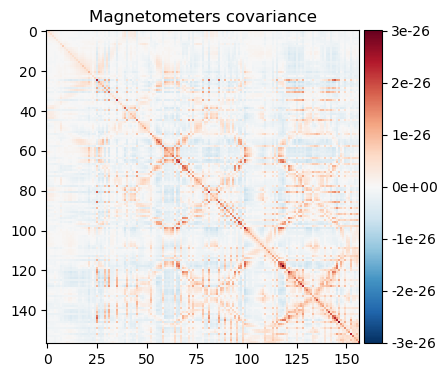

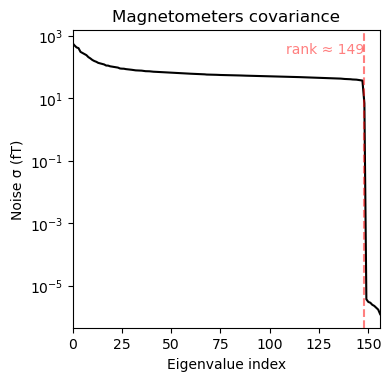

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [53]:
rank = {'mag': 149}
noise_cov_comp = mne.compute_covariance(epochs_aud_comp, tmin=baseline_start, tmax=baseline_end,
                                        method=["shrunk", "empirical"], rank=rank, verbose=True)
mne.viz.plot_cov(noise_cov_comp, aud_comp.info)

In [54]:
raw_fname_comp = directory + sub + '_comp_preproc-raw.fif'
trans = directory + sub + '-trans.fif'

# Compute forward solution
fwd_comp = mne.make_forward_solution(
    raw_fname_comp,
    trans=trans,
    src=src,
    bem=bem,
    meg=True,
    eeg=False,
    mindist=5.0,
    ignore_ref=True
)
lambda2 = 1.0 / snr ** 2

# Calculate inverse operators
inverse_aud_comp = make_inverse_operator(aud_comp.info, fwd_comp, noise_cov_comp, loose=0.2, depth=0.8)

# Calculate STCs using evoked data, inverse operators from above
stc_aud_comp = apply_inverse(aud_comp, inverse_aud_comp, lambda2, method=method, pick_ori="normal")

fname_aud_comp = directory + sub + '_aud_comp'
stc_aud_comp.save(fname_aud_comp, ftype='stc', overwrite=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'R3271', ~31.3 MiB>
MRI -> head transform : /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3271/R3271-trans.fif
Measurement data      : R3271_comp_preproc-raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999769 0.021002 -0.004619      -2.91 mm
    -0.020742 0.998507 0.050524      25.95 mm
    0.005673 -0.050417 0.998712      36.61 mm
    0.000000 0.000000 0.000000       1.00

Read 157 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.989188 0.073480 -0.126917      -6.93 mm
    -0.033062 0.954878 0.295153       3.07 mm
    0.1

## Production

    Created an SSP operator (subspace dimension = 2)
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 157 -> 149
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 90300
log-likelihood on unseen data (descending order):
   shrunk: -837.925
   empirical: -837.926
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 1.8e-14 (2.2e-16 eps * 157 dim * 0.51  max singular value)
    Estimated rank (mag): 149
    MAG: rank 149 computed from 157 data channels with 0 projectors


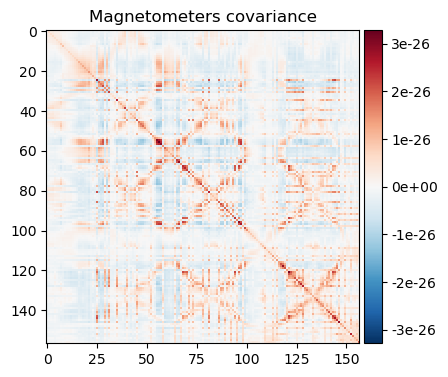

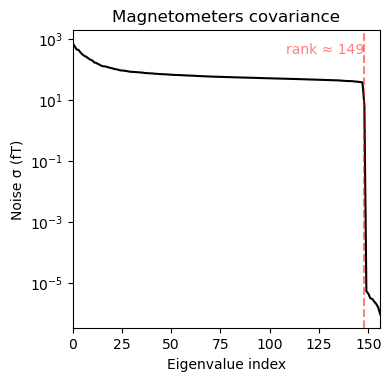

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [55]:
rank = {'mag': 149}
noise_cov_prod = mne.compute_covariance(epochs_aud_prod, tmin=baseline_start, tmax=baseline_end,
                                        method=["shrunk", "empirical"], rank=rank, verbose=True)
mne.viz.plot_cov(noise_cov_prod, aud_prod.info)

In [56]:
raw_fname_prod = directory + sub + '_prod_preproc-raw.fif'
trans = directory + sub + '-trans.fif'

# Compute forward solution
fwd_prod = mne.make_forward_solution(
    raw_fname_prod,
    trans=trans,
    src=src,
    bem=bem,
    meg=True,
    eeg=False,
    mindist=5.0,
    ignore_ref=True
)
lambda2 = 1.0 / snr ** 2

# Calculate inverse operators
inverse_aud_prod = make_inverse_operator(aud_prod.info, fwd_comp, noise_cov_prod, loose=0.2, depth=0.8)

# Calculate STCs using evoked data, inverse operators from above
stc_aud_prod = apply_inverse(aud_prod, inverse_aud_prod, lambda2, method=method, pick_ori="normal")

fname_aud_prod = directory + sub + '_aud_prod'
stc_aud_prod.save(fname_aud_prod, ftype='stc', overwrite=True)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=163842, n_used=4098>, <surface (rh), n_vertices=163842, n_used=4098>] MRI (surface RAS) coords, subject 'R3271', ~31.3 MiB>
MRI -> head transform : /Users/audreylaun/Library/CloudStorage/Box-Box/Starling/Experiment1/MEG_data/R3271/R3271-trans.fif
Measurement data      : R3271_prod_preproc-raw.fif
Conductor model   : instance of ConductorModel
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999769 0.021002 -0.004619      -2.91 mm
    -0.020742 0.998507 0.050524      25.95 mm
    0.005673 -0.050417 0.998712      36.61 mm
    0.000000 0.000000 0.000000       1.00

Read 157 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.989857 0.078021 -0.118724      -6.95 mm
    -0.037695 0.949985 0.310013       3.55 mm
    0.1

In [50]:
stcs = {
        'Auditory Comprehension':stc_aud_comp,
        'Auditory Production': stc_aud_prod,
}

brains = []

cmaps = ['hot', 'cool']
for (title, stc), cmap in zip(stcs.items(), cmaps):
    brain = stc.plot(
        subjects_dir=subjects_dir,
        hemi='lh',
        colormap=cmap,
        clim=dict(kind="value", lims=[1, 3, 5]),
        smoothing_steps=7,
        title=title
    )
    brain.add_text(0.1, 0.9, title, "title", font_size=14)
    brains.append(brain)  # Save each brain object
